# Select parameters to register fluorescence images

This is for acquisition that have no rounds, but multiple channels to align.

- `binarise_quantile`: The quantile to use to binarise the moving image. The default
is `0.7`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iss_preprocess as iss

data_path = "becalia_rabies_barseq/BRAC8498.3e/chamber_08/"
prefix = "hybridisation_round_1_1"
projection = "max-median"
threshold_quantile = 0.9
block_size = 512
overlap = 0.8

ops = iss.io.load_ops(data_path)
tile_coors = ops["ref_tile"]
ref_ch = ops["ref_ch"]

/Users/blota/miniconda3/envs/iss-preprocess/lib/python3.12/site-packages/bg_atlasapi/__init__.py:5: DeprecationWarning: Implicit None on return values is deprecated and will raise KeyErrors.
  __author__ = metadata("bg-atlasapi")["Author"]


## Median filter

The images are first filtered with a median filter to remove noise. The size of the
filter is `ops["reg_median_filter"]`. The size does not need to be very large, it is 
just used to remove dead pixels and some regular noise.

Filtering with median filter of size 1


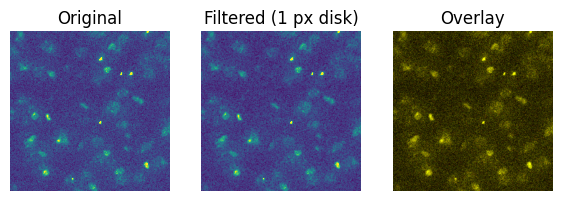

In [7]:
from skimage.morphology import disk
from scipy.ndimage import median_filter

stack_ori = iss.pipeline.load_tile_by_coors(
    data_path, tile_coors=tile_coors, suffix=projection, prefix=prefix
)

# median filter if needed
median_filter_size = ops["reg_median_filter"]
if median_filter_size is not None:
    print(f"Filtering with median filter of size {median_filter_size}")
    assert isinstance(median_filter_size, int), "reg_median_filter must be an integer"
    stack = median_filter(
        stack_ori.copy(), footprint=disk(median_filter_size), axes=(0, 1)
    )
else:
    stack = stack_ori

w = 512

fig = plt.figure(figsize=(7, 5))
vmin, vmax = np.percentile(stack[:w, :w, ref_ch], [1, 99.9])
plt.subplot(1, 3, 1)
plt.imshow(stack_ori[:w, :w, ref_ch], vmin=vmin, vmax=vmax)
plt.title("Original")
plt.subplot(1, 3, 2)
plt.imshow(stack[:w, :w, ref_ch], vmin=vmin, vmax=vmax)
plt.title(f"Filtered ({median_filter_size} px disk)")

rgb = iss.vis.to_rgb(
    np.dstack([stack_ori[:w, :w, ref_ch], stack[:w, :w, ref_ch]]),
    colors=[(1, 0, 0), (0, 1, 0)],
    vmin=(vmin, vmin),
    vmax=(vmax, vmax),
)
plt.subplot(1, 3, 3)
plt.imshow(rgb)
plt.title("Overlay")
for x in fig.axes:
    x.axis("off")

# Binarisation quantile

The binarisation is used to increase the importance of the shared background between
channels in the registration. It is applied on each block of the image independently,
but here to get an idea we just plot the whole image with one threshold.

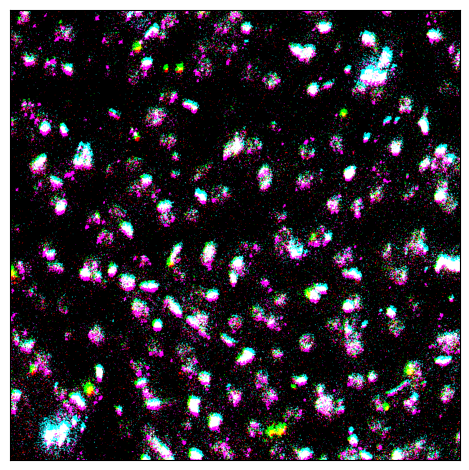

In [12]:
tl = (0, 0)  # top left of the part to plot
w = 1024
  # width of the part to plot
nch = stack.shape[2]
stack_bin = stack.copy()
if threshold_quantile is not None:
    for ich in range(nch):
        ref_thresh = np.quantile(stack[:, :, ich], threshold_quantile)
        stack_bin[:, :, ich] = stack[:, :, ich] > ref_thresh
        
rgb = iss.vis.to_rgb(
    stack_bin[tl[0] : tl[0] + w, tl[1] : tl[1] + w, :],
    colors=[(1, 0, 0), (0, 1, 0), (1, 0, 1), (0, 1,1)],
    vmin=[0] * nch,
    vmax=[1] * nch,
)

plt.imshow(rgb)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

# Block size and overlap

The registration will be done in blocks. The size of the blocks should be big enough
to make sure that there is enough shared information between the channels, but small
enough to ensure we can get local variation. The overlap should be high enough to get a 
decent fit from the shifts.

Filtering with median filter of size 1
Channel 1 affine: [ 1.000e+00  3.000e-03 -9.700e-02 -3.000e-03  1.000e+00  7.257e+00]
Channel 2 affine: [ 1.    -0.002  0.     0.002  0.999 -1.643]
Channel 3 affine: [ 9.990e-01 -1.000e-03 -1.552e+00  1.000e-03  9.990e-01  6.769e+00]


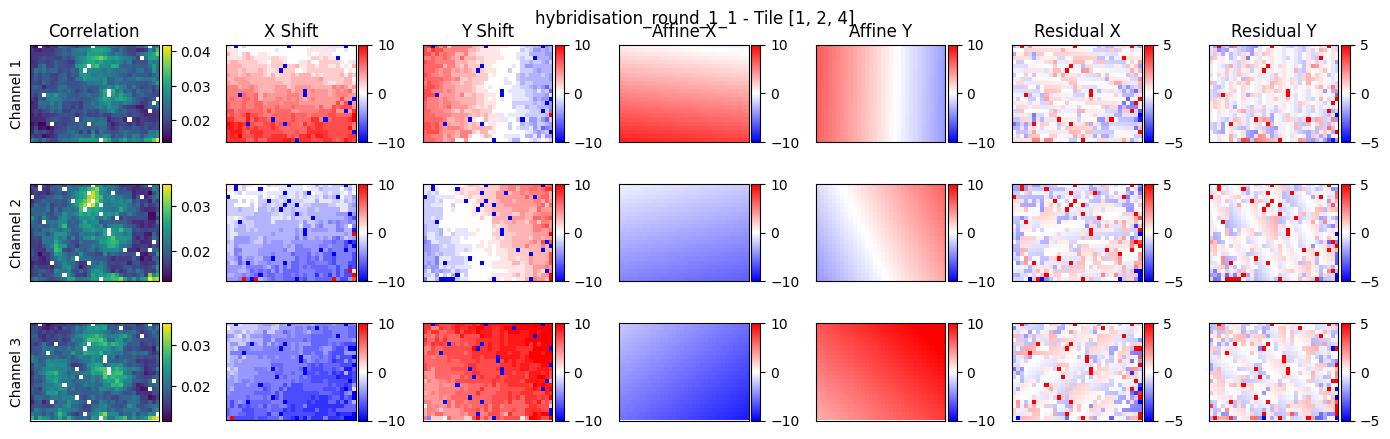

In [13]:
# remove the runtime warning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
tile_coors, matrices, debug_info = (
    iss.pipeline.diagnostics.check_affine_channel_registration(
        data_path,
        prefix="hybridisation_round_1_1",
        tile_coords=ops["ref_tile"],
        projection=projection,
        binarisation_quantile=threshold_quantile,
        block_size=block_size,
        overlap=overlap,
    )
)
warnings.filterwarnings("default")

# Final results

That should look pretty

Text(0.5, 0.98, '512 block, 0.8 overlap, 0.9 quantile binarisation')

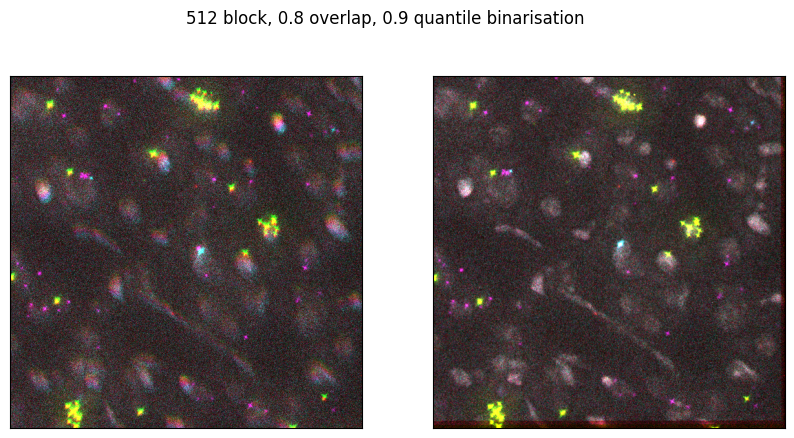

In [14]:
corrected_hyb = iss.reg.rounds_and_channels.apply_corrections(
    stack_ori, matrix=matrices, cval=0.0
)
vmax = np.percentile(corrected_hyb, 99.9, axis=(0, 1))
vmin = np.percentile(corrected_hyb, 1, axis=(0, 1))

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
rgb = iss.vis.to_rgb(
    stack_ori, colors=[(1, 0, 0), (0, 1, 0), (1, 0, 1), (0, 1, 1)], vmin=vmin, vmax=vmax
)
plt.imshow(rgb)
plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
rgb = iss.vis.to_rgb(
    corrected_hyb,
    colors=[(1, 0, 0), (0, 1, 0), (1, 0, 1), (0, 1, 1)],
    vmin=vmin,
    vmax=vmax,
)
plt.imshow(rgb)
ax.set_xlim(3290 - 512, 3290)
ax.set_ylim(0, 512)
ax.set_xticks([])
ax.set_yticks([])


fig.suptitle(f"{block_size} block, {overlap} overlap, {threshold_quantile} quantile binarisation")